In [129]:
import anndata
import pixelator
import torch
import scvi
import scipy
# from scvi import autotune

import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection


# import ray
# from ray import tune


from PixelGen.pxl_utils import *
from PixelGen.scvi_utils import plot_validation_loss
from PixelGen.tests import test_convert_edgelist_to_protein_pair_colocalization

from pixelator.statistics import clr_transformation


import tempfile

from scvi import REGISTRY_KEYS
from scvi.module.base import (
    BaseModuleClass,
    LossOutput,
    PyroBaseModuleClass,
    auto_move_data,
)
from torch.distributions import NegativeBinomial, Normal, Poisson
from torch.distributions import kl_divergence as kl

from PixelGen.modules import NormalVAE, NormalSCVI
from cytovi import CytoVI

print(torch.cuda.is_available())

%load_ext autoreload
%autoreload 2

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

Seed set to 0


True
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Last run with scvi-tools version: 1.2.2.post2


In [2]:
pg_data = pixelator.read('/home/labs/nyosef/eitangr/pixelgen/PixelGen/datasets/combined_resting_PHA_data_PROCESSED.pxl')
resting_adata = anndata.read_h5ad('/home/labs/nyosef/eitangr/pixelgen/PixelGen/datasets/resting_data_with_scores_annotated.h5ad')
stim_adata = anndata.read_h5ad('/home/labs/nyosef/eitangr/pixelgen/PixelGen/datasets/stim_data_with_scores_annotated.h5ad')

In [142]:
MARKER_NAMES = resting_adata.var_names.values

In [143]:
coloc_key = 'pearson'
all_obs = pd.concat((resting_adata.obs, stim_adata.obs), axis=0)
longform_coloc = pg_data.colocalization[['component', 'marker_1', 'marker_2', coloc_key]].join(all_obs['sample_class'], on='component')
longform_coloc['pair'] = [pair2str(m1, m2, sort=True) for m1, m2 in zip(longform_coloc['marker_1'], longform_coloc['marker_2'])]
for (sample_class, cur_adata) in zip(('resting', 'stimulated'), (resting_adata, stim_adata)):
    coloc = longform_coloc[longform_coloc['sample_class'] == sample_class]
    coloc = coloc.pivot(index='component', columns='pair', values=coloc_key)
    coloc = coloc.loc[cur_adata.obs.index]
    cur_adata.obsm['pearson'] = coloc

In [145]:
# resting_coloc = fill_with_mean(resting_adata.obsm['pixelgen_coloc'])
# stim_coloc = fill_with_mean(stim_adata.obsm['pixelgen_coloc'])
# resting_coloc = fill_with_mean(resting_adata.obsm['coloc_actual'] / resting_adata.obsm['coloc_normalization'])
# stim_coloc = fill_with_mean(stim_adata.obsm['coloc_actual'] / stim_adata.obsm['coloc_normalization'])
resting_coloc = resting_adata.obsm['pearson']
stim_coloc = stim_adata.obsm['pearson']

resting_coloc = fill_with_mean(resting_coloc)
stim_coloc = fill_with_mean(stim_coloc)

Text(0.5, 1.0, 'Stim - Resting')

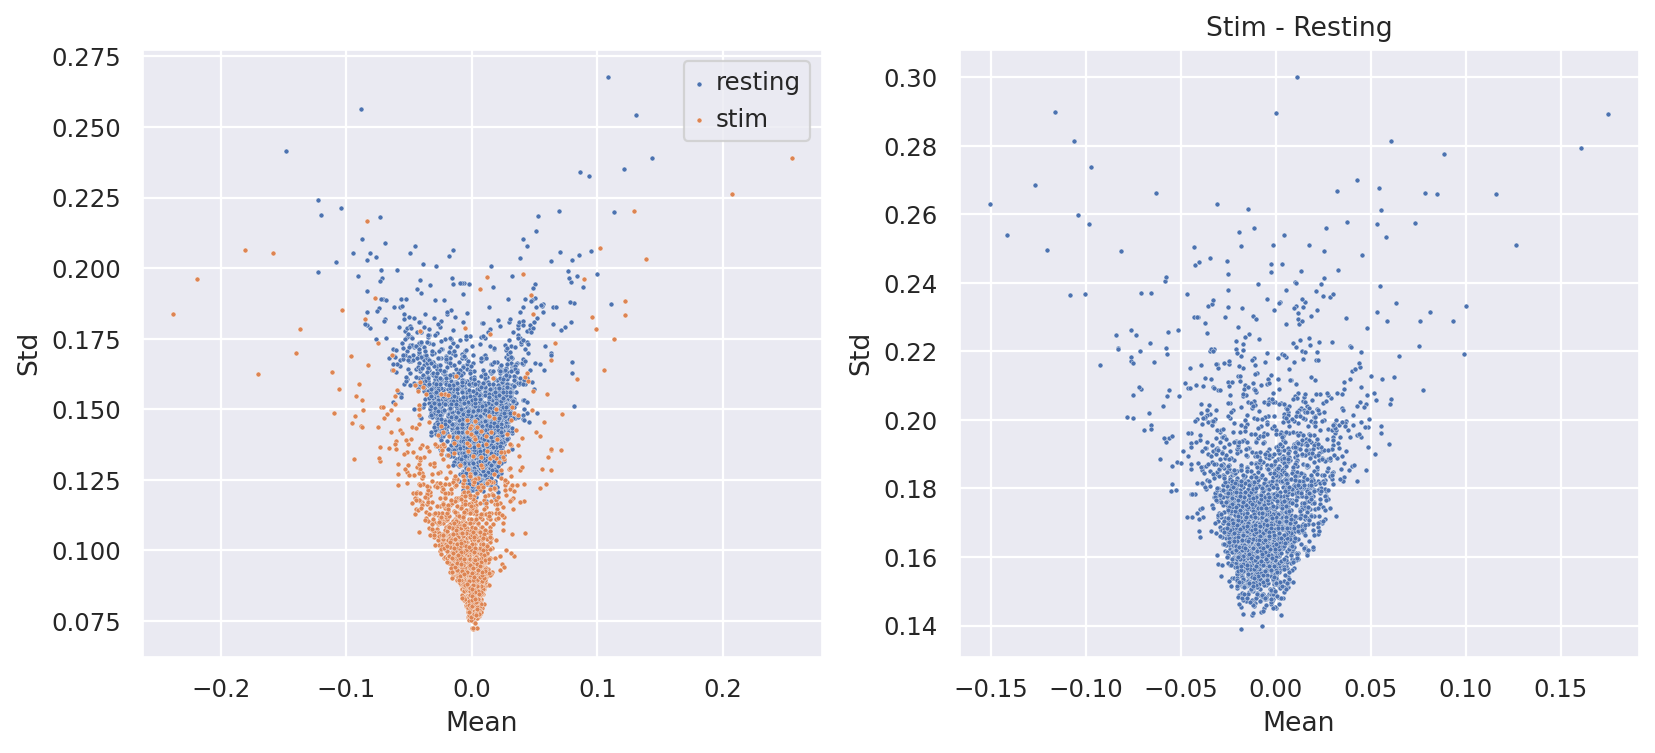

In [146]:
resting_mean, resting_std = resting_coloc.mean(axis=0), resting_coloc.std(axis=0)
stim_mean, stim_std = stim_coloc.mean(axis=0), stim_coloc.std(axis=0)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=resting_mean, y=resting_std, ax=ax[0], label='resting', s=5)
sns.scatterplot(x=stim_mean, y=stim_std, ax=ax[0], label='stim', s=5)
ax[0].set_xlabel('Mean')
ax[0].set_ylabel('Std')

sns.scatterplot(x=stim_mean - resting_mean, y=np.sqrt(np.square(resting_std)+np.square(stim_std)), ax=ax[1], s=5)
ax[1].set_xlabel('Mean')
ax[1].set_ylabel('Std')
ax[1].set_title('Stim - Resting')

In [147]:
resting_corrs = pairs_to_marginals_correlation(pd.concat((resting_adata.to_df('counts'), resting_coloc), axis=1), marker_names=MARKER_NAMES)
stim_corrs = pairs_to_marginals_correlation(pd.concat((stim_adata.to_df('counts'), stim_coloc), axis=1), marker_names=MARKER_NAMES)

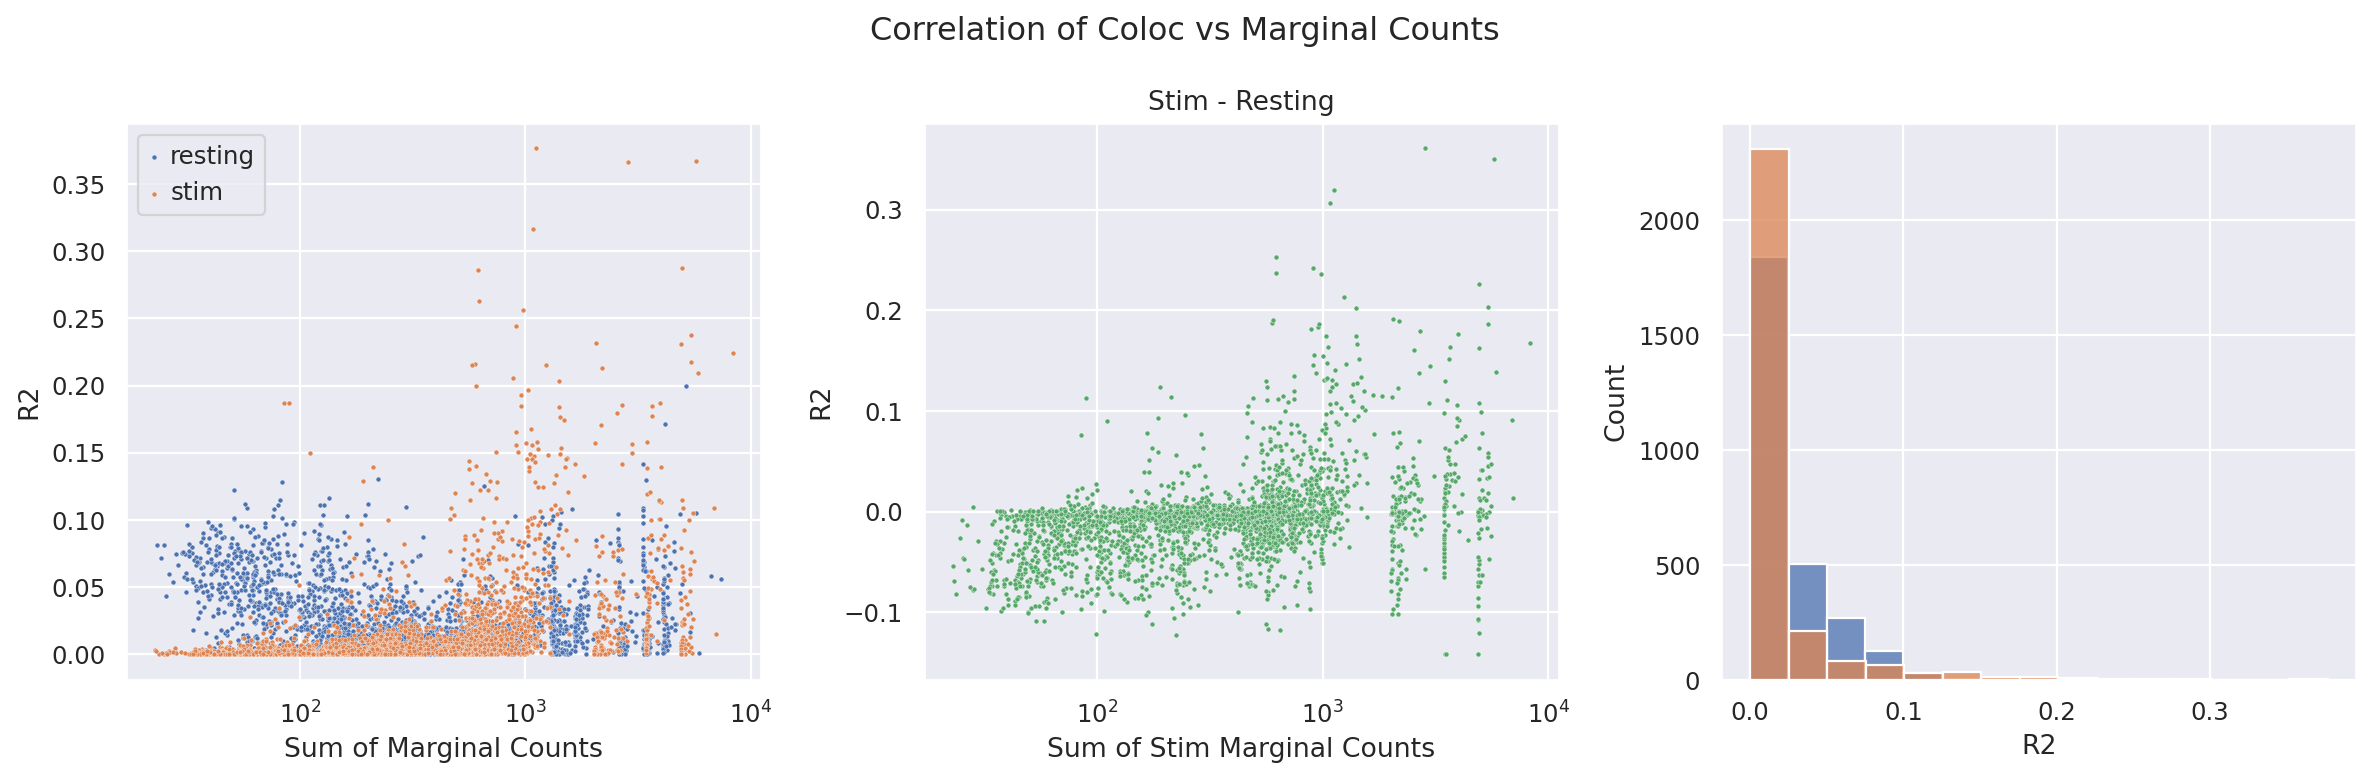

In [148]:
# resting_corrs['max_counts'] = np.maximum(resting_corrs['m1_mean_counts'], resting_corrs['m2_mean_counts'])
# stim_corrs['max_counts'] = np.maximum(stim_corrs['m1_mean_counts'], stim_corrs['m2_mean_counts'])
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(x=resting_corrs['m1_mean_counts'] + resting_corrs['m2_mean_counts'], y=resting_corrs['R2'], ax=ax[0], s=5, label='resting')
sns.scatterplot(x=stim_corrs['m1_mean_counts'] + stim_corrs['m2_mean_counts'], y=stim_corrs['R2'], ax=ax[0], s=5, label='stim')
ax[0].semilogx()
ax[0].set_xlabel('Sum of Marginal Counts')

sns.scatterplot(x=stim_corrs['m1_mean_counts'] + stim_corrs['m2_mean_counts'], y=stim_corrs['R2'] - resting_corrs['R2'], ax=ax[1], s=5, color=sns.color_palette()[2])
ax[1].semilogx()
ax[1].set_xlabel('Sum of Stim Marginal Counts')
ax[1].set_title('Stim - Resting')

sns.histplot(resting_corrs['R2'], ax=ax[2], label='resting', binwidth=0.025)
sns.histplot(stim_corrs['R2'], ax=ax[2], label='stim', binwidth=0.025)

fig.suptitle('Correlation of Coloc vs Marginal Counts')
fig.tight_layout()



In [149]:
resting_coloc_adata = anndata.AnnData(X=pd.concat((resting_adata.to_df('dsb'), resting_coloc), axis=1), obs=resting_adata.obs, obsm=resting_adata.obsm)
stim_coloc_adata = anndata.AnnData(X=pd.concat((stim_adata.to_df('dsb'), stim_coloc), axis=1), obs=stim_adata.obs, obsm=stim_adata.obsm)

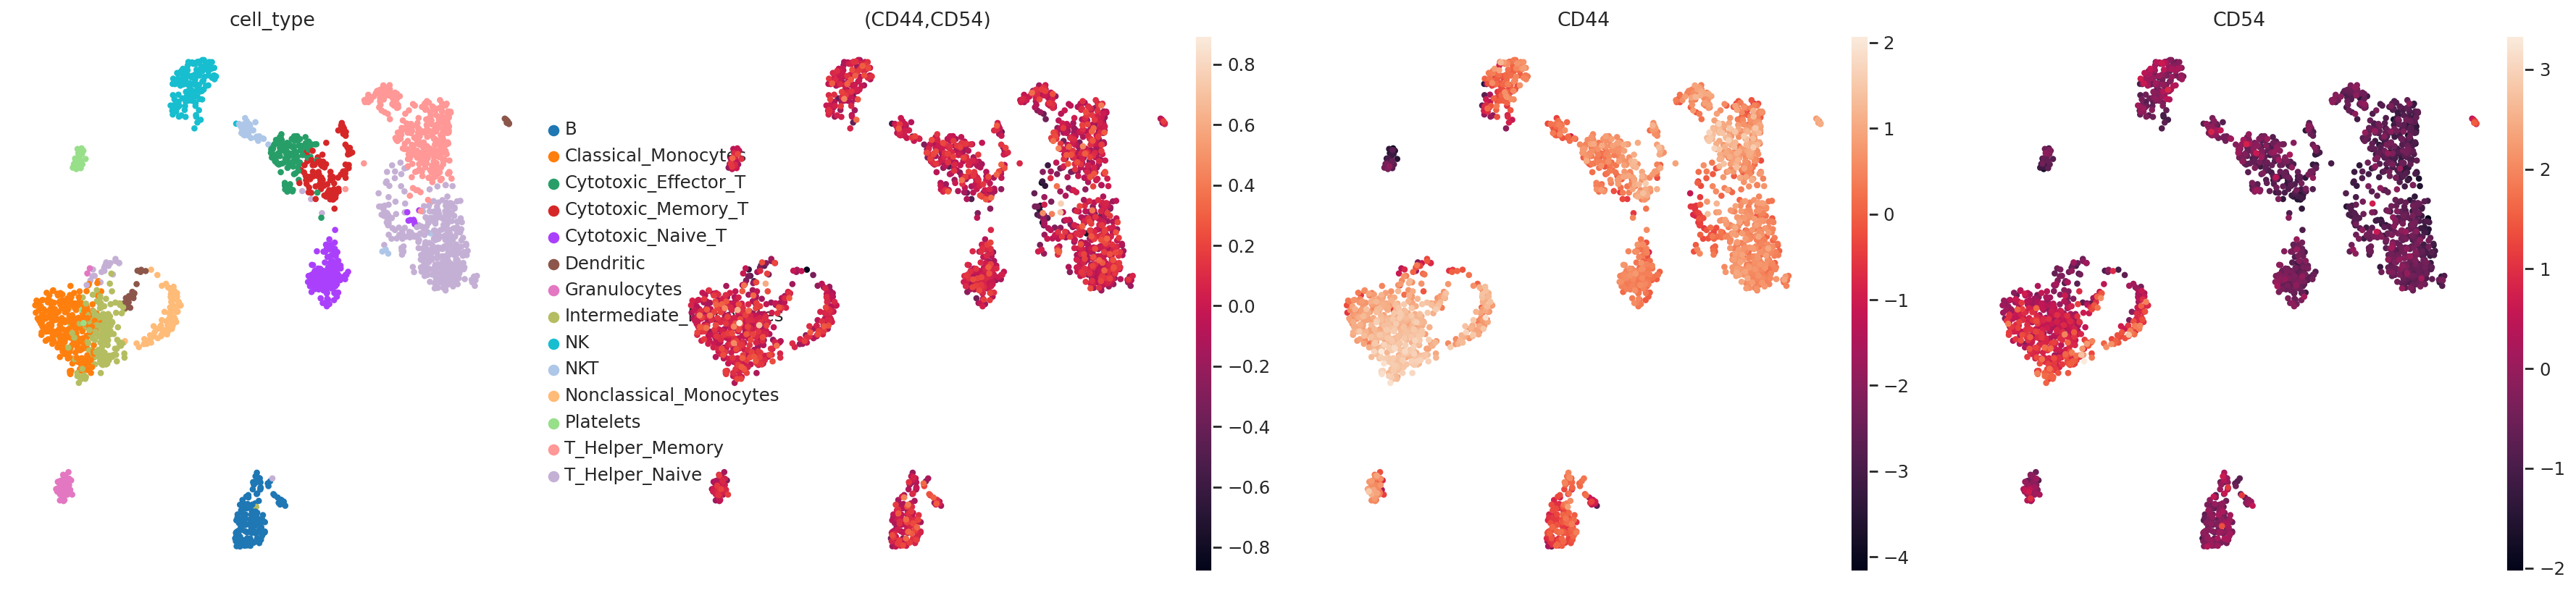

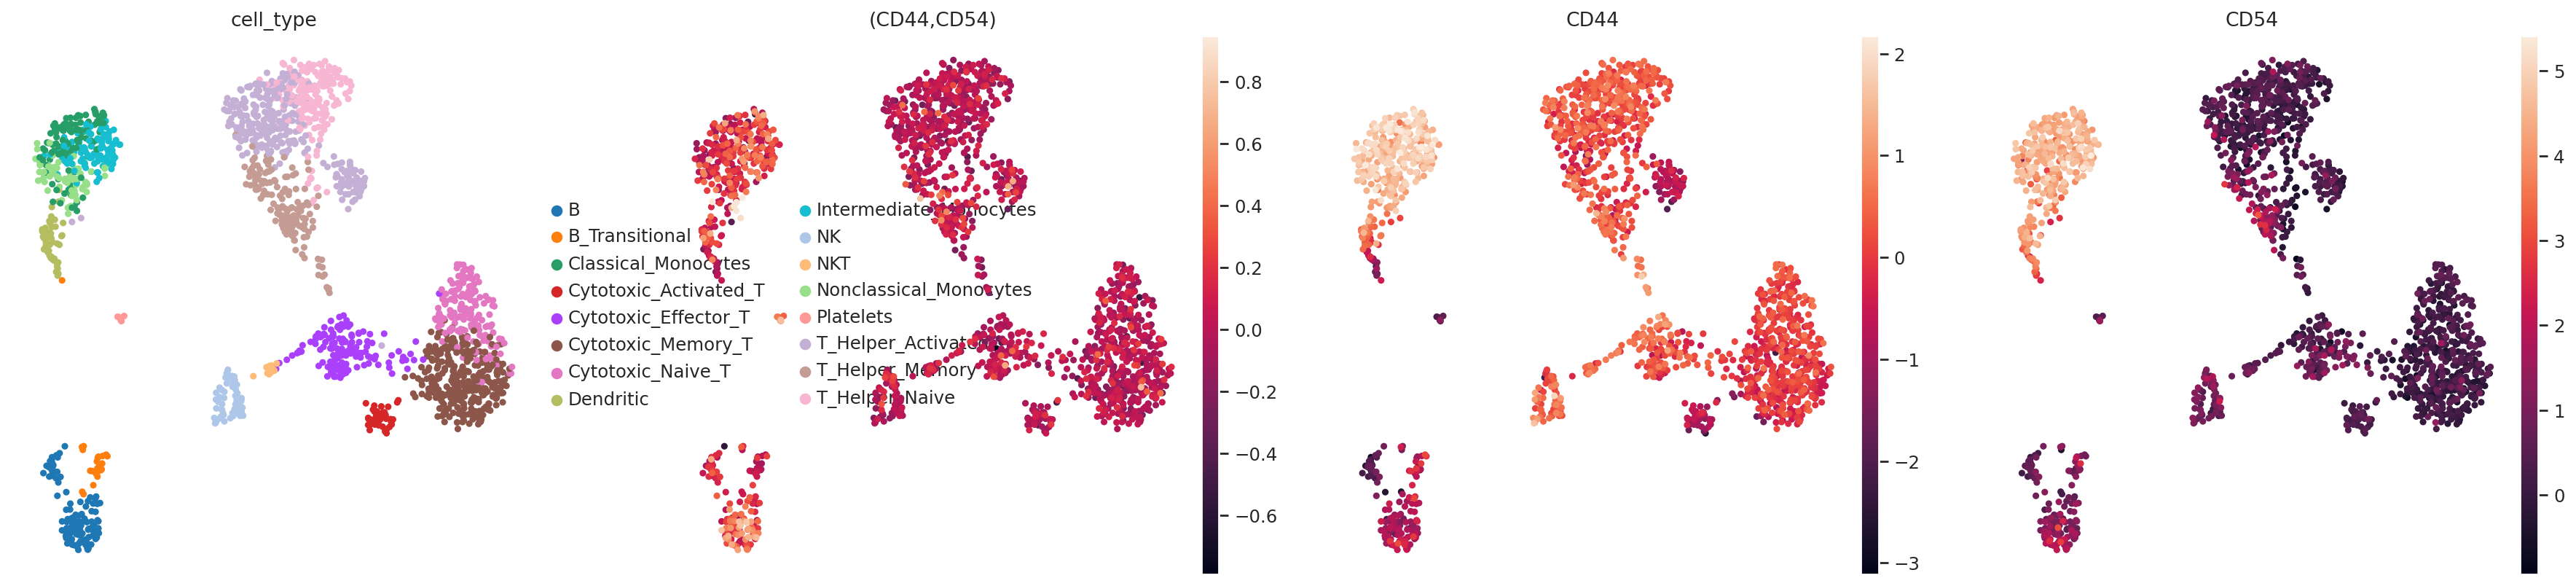

In [151]:
m1 = 'CD44'
m2 = 'CD54'
pair = pair2str(m1, m2, sort=True)
sc.pl.umap(resting_coloc_adata, color=['cell_type', pair, m1, m2])
sc.pl.umap(stim_coloc_adata, color=['cell_type', pair, m1, m2])

In [153]:
np.any(np.isnan(resting_coloc))

False

In [155]:
highly_variable = calc_hvg(rep=resting_coloc, n_top_genes=20)
hvg = highly_variable[highly_variable.highly_variable].index

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:305: RuntimeWarning:

invalid value encountered in log



/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning:

invalid value encountered in log2

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning:

invalid value encountered in log2

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning:

invalid value encountered in log2

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning:

invalid value encountered in log2

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning:

invalid value encountered in log2

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/scanpy/tools/_rank

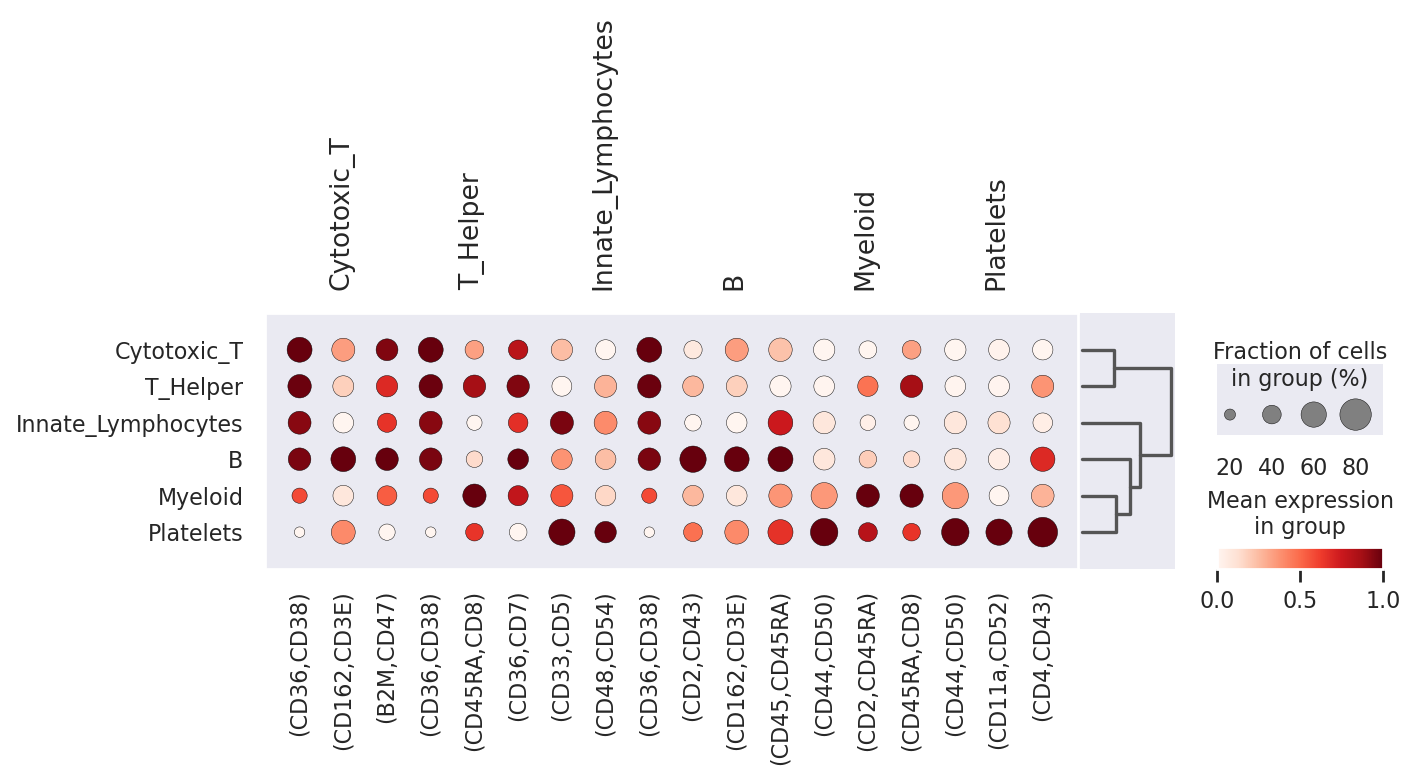

In [164]:
sc.tl.rank_genes_groups(resting_coloc_adata, groupby='low_res_cell_type', method='wilcoxon', mask_var=np.array([v in hvg for v in resting_coloc_adata.var_names], dtype=bool))
sc.pl.rank_genes_groups_dotplot(resting_coloc_adata, groupby='low_res_cell_type', standard_scale='var', n_genes=3)

In [84]:
[m for m in MARKER_NAMES if 'CD18' in m]

['CD18']

In [139]:
counts_df = resting_adata.to_df('dsb')
component = counts_df[counts_df['TCRVB5'] > 3].index[0]
# component = resting_adata.obs[resting_adata.obs['cell_type'] == 'Cytotoxic_Effector_T'].index[0]
resting_adata.to_df('counts').loc[component, [m1, m2]]

marker
CD3E      1529
TCRVB5     427
Name: RCVCMP0001326_resting_r1, dtype: int64

In [140]:
graph_layout_data = compute_graph_layout(pg_data, component=component)

In [141]:
plot_cell_smooth(graph_layout_data, marker_1=m1, marker_2=m2)

In [126]:
import numpy as np
import plotly.graph_objects as go
from scipy.interpolate import griddata

# --- Example scattered data ---
# Each tuple is (x, y, z, A, B). 
# Here, values are assumed to be normalized in [0,1].
# data = [
#     (0, 0, 1, 1, 0),                     # pure red at the north pole
#     (0.5, 0.5, np.sqrt(0.5), 0.5, 0.5),    # mix => purple-ish
#     (-0.5, -0.5, np.sqrt(0.5), 0, 1)        # pure blue
# ]
# data = np.array(data)
# points = data[:, :3]  # (x, y, z) coordinates
# A_values = data[:, 3]
# B_values = data[:, 4]

# --- Create a spherical grid ---
n_theta = 100  # number of points along polar angle (theta)
n_phi   = 100  # number of points along azimuth (phi)

theta = np.linspace(0, np.pi, n_theta)
phi = np.linspace(0, 2 * np.pi, n_phi)
# Create a meshgrid where theta varies along rows and phi along columns
phi_grid, theta_grid = np.meshgrid(phi, theta)

# Parametric equations for a unit sphere:
x_sphere = np.sin(theta_grid) * np.cos(phi_grid)
y_sphere = np.sin(theta_grid) * np.sin(phi_grid)
z_sphere = np.cos(theta_grid)

data = pd.DataFrame({'x': x_sphere.flatten(), 'y': y_sphere.flatten(), 'z': z_sphere.flatten()})
data = data.sample(n=100, axis=0, random_state=0)
data['A'] = [1]*66 + [0]*34
data['B'] = [0]*34 + [1]*66

data = np.array(data)
points = data[:, :3]  # (x, y, z) coordinates
A_values = data[:, 3]
B_values = data[:, 4]

# Flatten the sphere coordinates for interpolation
pts_sphere = np.column_stack((x_sphere.flatten(), y_sphere.flatten(), z_sphere.flatten()))

# --- Interpolate A and B on the sphere surface ---
# For points where data is missing, fill with 0 (black)
A_interp = griddata(points, A_values, pts_sphere, method='linear', fill_value=0)
B_interp = griddata(points, B_values, pts_sphere, method='linear', fill_value=0)

# Reshape interpolated values back to the grid shape
A_interp = A_interp.reshape(x_sphere.shape)
B_interp = B_interp.reshape(x_sphere.shape)

# --- Compute per-vertex colors ---
# We want each vertex to have an RGB color of (int(255*A), 0, int(255*B))
# where missing data (A=B=0) gives black.
colors = np.empty(x_sphere.shape, dtype=object)
for i in range(x_sphere.shape[0]):
    for j in range(x_sphere.shape[1]):
        r = int(np.clip(A_interp[i, j] * 255, 0, 255))
        b = int(np.clip(B_interp[i, j] * 255, 0, 255))
        colors[i, j] = f'rgb({r},0,{b})'

# --- Build the mesh for go.Mesh3d ---
# Flatten the grid arrays (each vertex)
x_flat = x_sphere.flatten()
y_flat = y_sphere.flatten()
z_flat = z_sphere.flatten()
vertex_colors = colors.flatten()

# Create the triangular faces.
# The grid is (n_theta x n_phi) so each cell forms two triangles.
triangles = []
for i in range(n_theta - 1):
    for j in range(n_phi - 1):
        idx = i * n_phi + j
        idx_right = idx + 1
        idx_down = idx + n_phi
        idx_down_right = idx_down + 1
        # Triangle 1 of the cell:
        triangles.append([idx, idx_right, idx_down])
        # Triangle 2 of the cell:
        triangles.append([idx_right, idx_down_right, idx_down])
triangles = np.array(triangles)

# --- Create the Mesh3d trace ---
mesh = go.Mesh3d(
    x=x_flat,
    y=y_flat,
    z=z_flat,
    i=triangles[:, 0],
    j=triangles[:, 1],
    k=triangles[:, 2],
    vertexcolor=vertex_colors,  # assign our per-vertex colors
    flatshading=True,
    showscale=False  # no color scale bar
)

# --- Plot the figure ---
fig = go.Figure(data=[mesh])
fig.update_layout(
    scene=dict(aspectmode='data'),
    title="Unit Sphere with Smooth Interpolated Gradient"
)
fig.show()